In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import warnings;
warnings.filterwarnings('ignore');

### Dataset

In [ ]:
import pandas as pd
import pandas as pd

df = pd.read_csv("result/01_date_preprocessing_result.csv",sep=",")
df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking,Complaint_tokenized_text
0,0,purchase order day shipping amount receive pro...,1705,True,False,False,False,False,"[['purchase', 'order', 'day', 'shipping', 'amo..."
1,1,forwarded message date tue subject please inve...,904,True,False,False,False,False,"[['forwarded', 'message', 'date', 'tue', 'subj..."
2,2,forwarded message cc sent friday pdt subject f...,1230,False,False,False,False,True,"[['forwarded', 'message', 'cc', 'sent', 'frida..."
3,3,payment history missing credit report speciali...,903,False,True,False,False,False,"[['payment', 'history', 'missing', 'credit', '..."
4,4,payment history missing credit report made mis...,851,False,True,False,False,False,"[['payment', 'history', 'missing', 'credit', '..."


### Splitting Data

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45959 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (162411, 250)


In [ ]:
y = np.argmax(df[['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']].values, axis=1)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(103942, 250) (103942,)
(32483, 250) (32483,)


### Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Embedding, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Function to build the CNN model with one hidden layer
def build_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS,  EMBEDDING_DIM, input_shape=(X_train.shape[1],)))

    # LSTM 
    model.add(Bidirectional(GRU(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))   
    model.add(Dense(5,activation='softmax'))  
   
    return model

In [ ]:
# Build the CNN model
model = build_model()
# Menampilkan ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 250, 16)        │         7,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,007,573 (19.10 MB)

 Trainable params: 5,007,573 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
num_epochs = 5
batch_size = 500
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
## For early stopping to ensure it doesnt overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(X_train, y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)])

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 114s 584ms/step - accuracy: 0.5562 - loss: 1.2212 - val_accuracy: 0.8255 - val_loss: 0.5492
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 132s 702ms/step - accuracy: 0.8339 - loss: 0.5179 - val_accuracy: 0.8509 - val_loss: 0.4507
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 116s 615ms/step - accuracy: 0.8595 - loss: 0.4223 - val_accuracy: 0.8564 - val_loss: 0.4202
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 125s 665ms/step - accuracy: 0.8737 - loss: 0.3746 - val_accuracy: 0.8624 - val_loss: 0.4021
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 132s 703ms/step - accuracy: 0.8855 - loss: 0.3467 - val_accuracy: 0.8662 - val_loss: 0.3949


In [ ]:
# Ambil loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

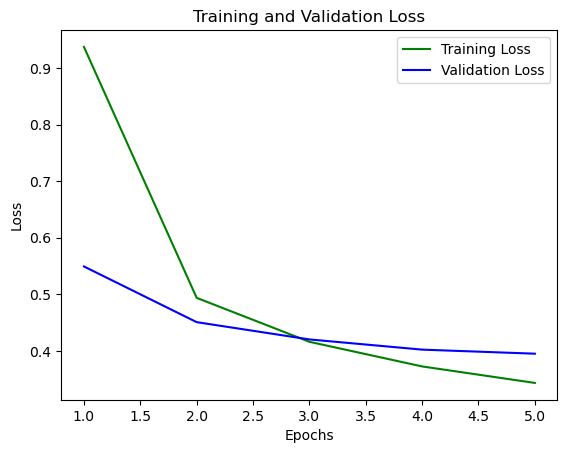

In [ ]:
# Plot kurva loss
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Mengevaluasi kinerja model menggunakan data validasi
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Model Validation Accuracy:", val_acc)

813/813 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.8672 - loss: 0.4008
Model Validation Accuracy: 0.8658508658409119


### Evaluating the Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.8691 - loss: 0.3875
Test loss: 0.39204660058021545
Test accuracy: 0.8671612739562988


# RNN
<hr>